# [IAPR][iapr]: Project


**Group ID:** 40

**Author 1 (sciper):** Raphael Uebersax (283249)
**Author 2 (sciper):** Chuanfang Ning (320662)
**Author 3 (sciper):** Noppawit Lertutsahakul (321592)

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59) 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous researcher that we will name Lann Yecun is convinced that the MNIST dataset still has great potential. He decides to create a playing card game based on MNIST digits and different figures. The game uses a standard 52 card deck which is composed of four French suits/colours: clubs (&#9827;), diamonds (&#9830;), hearts (&#9829;) and spades (&#9824;). Each suit includes 10 digit cards (from 0 to 9) and 3 figures (Jack-J, Queen-Q, and King-K). Here is an example of the 13 spade cards with their name.


<img src="media/example_cards.jpg">


We can find the same arrangement of cards for the clubs, diamonds, and hearts. 


## 1. Rules


### 1.1 Standard

The rules are based on the simple battle card game. The goal of the game is to win as many points as possible. Each turn, the 4 players play a card in front of them. As displayed in the example below. The rules are the following:

- The cards are ranked in the following order : **0 < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < J < Q < K**.
- The player with the highest-ranked card wins the round and obtains **1 point**. 
- If the highest-ranked card is the same for multiple players we call it a draw and all winners get **1 points**. 
- In this configuration, we **do not** take into account the suits. The game only rely on the card ranks. 
- The game lasts 13 rounds. After the last round, the winner is the player that has the largest number of points. 
- In the example below Player 1 wins the round with his Queen ( 0 < 8 < J < **Q**).

If two or more players have the same number of points they share the victory.

### 1.2 Advanced

The advanced rules take into account the suits. 

- At the beginning of **each round** a random player is designated as the **dealer**. The dealer places a green token with the letter *D* next to him (player 1 in the example below).
- Only the cards that belong to the same suit as the one of the dealer are considered valid. In the example below, only Player 4 is competing with Player 1 as spade was selected by the dealer (e.i., Player 1). Player 2 and 3 are out for this round. Player 1 wins the round and **1 point** with the Queen ( 0&#9824; < **Q&#9824;**).
- There cannot be any draw between the players as they are not any card duplicates.
- We use the same system as the standard method to count the points.


### 1.3 Notes

- The orientation of the card is linked to the position of the player around the table. For instance, to read the card of the 3rd player you will have to rotate it by 180°.
- The **digits** always **face** the players around the table. The figures can have random orientations.
- Player 1 **always** seats south of the table. The players are **always** ordered counter-clockwise as in the example. 
- The dealers can change between the rounds and games.
- Some cards might apear multiple times per game.

<img src="media/example_round.jpg">


---
## 2. Data

You will be given the images of 7 games that were played ([download link](https://drive.google.com/file/d/1lsCMEwc00nsBMVrzo0NE1np79dMeShqZ/view?usp=sharing)). The data are composed of:
   - 7 folder named after the games (game1 to game7).
   - Each game includes 13 ordered images (1st to 13th round).
   - Each game includes a csv file with the ground truth of the game. The first row list the players (P1 to P4) as well as the dealer (D). The following rows represent the rounds (1 to 13). We represent the card played with 2 character as $AB$ where $A \in [0-9, J, Q, K]$ is the rank of the card and $B \in [C, D, H, S]$ is the suit. For example, QS means "(Q)ueen of (S)pade". The dealer is represented by the ID of the player (e.g. P1 -> 1).
   
You are free to use external datasets such as the original MNIST train set that you used in lab 3.

---
## 3. Your Tasks

Your task is to ready yourself for the final evaluation. The day of the exam we will give you a new folder with a new game. ! The digits on the cards might sligthly **differ** from the one of the traning set. When given a new data folder with 13 images your should be able to:

**Task 0**
   - Plot an overlayF fr each round image that shows your detections and classification. You can for example plot bounding boxes around the cards/dealer token and add a text overlay with the name of the classes.

**Task 1**
   - (a) Predict the **rank** of the card played by each player at each round (Standard rules).
   - (b) Predict the **number of points** of each player according to **Standard** rules
 
**Task 2**
   - (a) Detect which player is the selected **dealer** for each round.
   - (b) Predict the **rank** and the **suit** of the card played by each player at each round (Advanced rules).
   - (c) Predict the **number of points** of each player according to **Advanced** rules


You will have to upload your code on moodle **the day before** the exam.

We will ask you to run your pipeline in realtime and to send us your prediction of task 1 and 2 obtain with the function **print_results**. On our side we will compute the perfomance of your classification algorithm. To evaluate your method we will use the **evaluate_game** function presented below. To understant how the provided functions work please read the documentation of the functions in **utils.py**.

**Please make sure your function returns the proper data format to avoid points penalty the day of the exam**. 

### Import dependencies

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
import sympy as sym
import math
import skimage
import skimage.morphology
import skimage.io
import os
import pandas as pd
from data.classifier import ValueClassifier
from data.utils import *

### Segmentation functions

The goal of this task is to extract the digit and the suit of the card each player player. Additionally, the position of the dealer also needs to be detected and assigned to one player. To do this, the idea is to first downscale the image for faster computation and then transform the it to the HSV space. Then, a green mask combine with a blue mask is used to detect all card edges, the dealer as well as the small blue line on the dealer. Doing that in the HSV space rather than on the RGB image has the advantage to be far more robust to difference in lightening. Having the binary image, the idea is to then perform opening on it to remove all cards and keep only the dealer chip. This enables to identify the dealer and to assign it to one player based on its center point location. For identifying the cards only, one can then remove the dealer chip from the binary image, perform closing to connect edges and do contour detection. The four biggest contours correspond to the cards are which can be identified using bounding boxes.

In [46]:
def clean_img(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #blur the image for thresholding
    blur_im = cv2.GaussianBlur(gray_im,(3,3),0)
    #adaptive threshold OTSU
    ret, thresh_im = cv2.threshold(blur_im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #foreground is darker than background, so an inversion here
    thresh_im = 255 - thresh_im
    return thresh_im

In [47]:
# define a downscaling factor for faster pre-processing
rescale_factor = 0.25

# define two structuring elements that will be used in the segmentation part
disk1 = skimage.morphology.disk((int)(35*rescale_factor))
disk2 = skimage.morphology.disk((int)(13*rescale_factor))

In [48]:
def find_green_boxes(image,debug=False):

    image = cv2.resize(image,None,fx=rescale_factor, fy=rescale_factor, interpolation = cv2.INTER_LINEAR) # Rescale
    hsv_fg = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)                                                       # Convert to HSV
    green_mask = cv2.inRange(hsv_fg, (25,35,35), (95, 255,255))                                           # Green mask
    blue_mask = cv2.inRange(hsv_fg, (80,110,110), (150, 255,255))                                         # Blue mask
    
    ## Slice the green and the blue
    binary = green_mask>0 
    binary_2 = blue_mask>0 
    binary = binary | binary_2
    
    # Detect dealer chip
    dealer = skimage.morphology.opening(binary, disk1)
    dealer = skimage.morphology.closing(dealer, disk1)
    
    # Detect cards
    cards = binary ^ dealer
    cards = skimage.morphology.closing(cards, disk2)
    cards = skimage.img_as_ubyte(cards)
    
    if (debug):
        green = np.zeros_like(image)
        green[binary] = image[binary]
        return cards, dealer, green
    else:
        return cards, dealer

In [49]:
def crop_suite_value_MNIST(card_img):
    # Crop the suite
    suite_img = card_img[37:197, 20:135]

    # Crop the value
    value_img = card_img[171:541, 43:413]

    # Make it look like MNIST samples
    value_img = cv2.cvtColor(value_img, cv2.COLOR_BGR2GRAY)
    value_img = 255 - value_img
    _, value_img = cv2.threshold(value_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    value_img = cv2.GaussianBlur(value_img,(25,25),0)
    value_img = cv2.resize(value_img, (28, 28), interpolation = cv2.INTER_CUBIC)
    value_img = cv2.blur(value_img, (2,2), 0)

    return suite_img, value_img

As explained previously, having binary images contained only the dealer chip and the cards, it is possbile to perform contour detection and keep the four biggest. Then, bounding boxes are matched with every image, the rotation angle retruned and first order moment can be extrected to get the center point. Using the rotation angle and center point, it is possible to crop the digit out of the image to be then further analysed. Similarly, by detecting the vector linking an corner point to the center point, it is possble to find approximately the location of the suit. The suit is then also croped using the rotation angle.

In [50]:
def segmentation(cards_im, dealer_im, original_im):

    #get height and width of image
    height, width = original_im.shape[0], original_im.shape[1]

    # We use RETR_EXTERNAL mode to find external contour.
    contour = cv2.findContours(cards_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0] 
    
    # Keep the biggest contour only
    contour = sorted(contour, key=cv2.contourArea,reverse=True)
    contours_list = []
    for i in range(4):
        contours_list.append(contour[i][:, 0, :])
    
    contours_card = []
    M_card = []
    upper_left = []
    upper_right = []
    crop_imgs = []
    angles = []
    sizes = []
    for contour in contours_list:
        # Compute convex hull of contour
        hull = cv2.convexHull(contour)[:,0,:]
        hull = (1/rescale_factor * hull).astype(int)
        
        # Make sure contour is continuous
        if np.any(hull[0,:]!= hull[-1,:]):
            hull = np.vstack((hull,hull[0,:]))
            
        ##crop the tilted card as rectangle img
        # get min rect area enclosing contour
        rect = cv2.minAreaRect((1/rescale_factor * contour).astype(int)) 
        center, size, angle = rect[0], rect[1], rect[2]
        angles.append(angle)
        sizes.append(size)
        center, size = tuple(map(int, center)), tuple(map(int, size))
        # return tuple type: (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(points)
        box = cv2.boxPoints(rect)
        # keep box points for plotting function
        box = np.int0(box)
        # calculate the rotation matrix of card
        M = cv2.getRotationMatrix2D(center, angle, 1)
        # rotate the original image by the calculated matrix
        original_im_rot = cv2.warpAffine(original_im, M, (width, height))
        # crop the rotated rectangle is vertical to the card in for loop
        crop_img = cv2.getRectSubPix(original_im_rot, size, center)

        if crop_img.shape[0] < crop_img.shape[1]:
            crop_img_rescaled = cv2.resize(crop_img,(712, 466), interpolation = cv2.INTER_CUBIC)
        else:
            crop_img_rescaled = cv2.resize(crop_img,(466, 712), interpolation = cv2.INTER_CUBIC)
        crop_imgs.append(crop_img_rescaled)
        
        upper_left_corner = np.argmin(np.sum(box,axis=1))
        diag_vect_left = np.array([rect[0][0]-box[upper_left_corner,0], rect[0][1]-box[upper_left_corner,1]])
        
        if upper_left_corner == 3:
            upper_right_corner = 0
        else:
            upper_right_corner = upper_left_corner + 1
        
        # Diagonal vector to crop the suit
        diag_vect_right = np.array([rect[0][0]-box[upper_right_corner,0], rect[0][1]-box[upper_right_corner,1]])
        
        # Keep only the four corners of the bounding box
        box = np.vstack((box,box[0,:]))
        center = rect[0]
        M_card.append(center)
        contours_card.append(box)
        upper_left.append(diag_vect_left)
        upper_right.append(diag_vect_right)

            
    # If contour is not a rectange (circle in our case)
    dealer_im = skimage.img_as_ubyte(dealer_im)
    # We use RETR_EXTERNAL mode to find external contour.
    contour_deal = cv2.findContours(dealer_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0] 
    
    # Keep the biggest contour only
    contour_deal = contour_deal[0][:,0,:]
    hull = cv2.convexHull(contour_deal)[:,0,:]
    hull = (1/rescale_factor*hull).astype(int)
    contour_dealer = hull
    M = cv2.moments(hull)
    cX = int(M["m10"] /M["m00"])
    cY = int(M["m01"] / M["m00"])
    M_dealer = np.array([cX,cY])
            
    # Assign moments to respective players   
    M_card_array = np.array(M_card)
    
    # sort player number
    player_one = np.argmax(M_card_array[:,1]) #max y in upper left corresponds to player 1 card upper left corner
    player_two = np.argmax(M_card_array[:,0]) #max x in upper right corresponds to player 2 card upper left corner
    player_three = np.argmin(M_card_array[:,1]) #min y in upper left corresponds to player 3 card upper left corner
    player_four = np.argmin(M_card_array[:,0]) #min x in upper right corresponds to player 4 card upper left corner

    # Segment player 1
    M_player_one = M_card_array[player_one,:]
    diag_one = upper_left[player_one]

    if sizes[player_one][0] < sizes[player_one][1]:
        crop_one = crop_imgs[player_one]
    elif sizes[player_one][0] >= sizes[player_one][1] and angles[player_one]<0:
        crop_one = cv2.rotate(crop_imgs[player_one], cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        crop_one = cv2.rotate(crop_imgs[player_one], cv2.ROTATE_90_CLOCKWISE)

    suit_one,crop_value_one = crop_suite_value_MNIST(crop_one)

    # Segment player 2
    M_player_two = M_card_array[player_two,:]
    diag_two = upper_right[player_two]
    
    if sizes[player_two][0] > sizes[player_two][1]:
        crop_two = cv2.rotate(crop_imgs[player_two], cv2.ROTATE_90_CLOCKWISE)
    elif sizes[player_two][0] <= sizes[player_two][1] and angles[player_two]<0:
        crop_two = crop_imgs[player_two]
    else:
        crop_two = cv2.rotate(crop_imgs[player_two], cv2.ROTATE_180)

    suit_two,crop_value_two = crop_suite_value_MNIST(crop_two)

    # Segment player 3
    M_player_three = M_card_array[player_three,:]
    diag_three = upper_left[player_three]

    if sizes[player_three][0] < sizes[player_three][1]:
        crop_three = cv2.rotate(crop_imgs[player_three], cv2.ROTATE_180)
    elif sizes[player_three][0] >= sizes[player_three][1] and angles[player_three]<0:
        crop_three = cv2.rotate(crop_imgs[player_three], cv2.ROTATE_90_CLOCKWISE)
    else:
        crop_three = cv2.rotate(crop_imgs[player_three], cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    suit_three,crop_value_three = crop_suite_value_MNIST(crop_three)

    # Segment player 4
    M_player_four = M_card_array[player_four,:]
    diag_four = upper_right[player_four]

    if sizes[player_four][0] > sizes[player_four][1]:
        crop_four = cv2.rotate(crop_imgs[player_four], cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif sizes[player_four][0] <= sizes[player_four][1] and angles[player_four]<0:
        crop_four = cv2.rotate(crop_imgs[player_four], cv2.ROTATE_180)
    else:
        crop_four = crop_imgs[player_four]

    suit_four,crop_value_four = crop_suite_value_MNIST(crop_four)

    # Combine the result
    M_player = [M_player_one, M_player_two, M_player_three, M_player_four]
    diag_card = [diag_one, diag_two, diag_three, diag_four]
    suit_img = [suit_one,suit_two,suit_three,suit_four]
    value_img = [crop_value_one,crop_value_two,crop_value_three,crop_value_four]

    M_suit = []
        
    for diag, M in zip(diag_card, M_player):
        M_suit_y = M[0]- (int)(diag[0]*6.8/10)
        M_suit_x = M[1]- (int)(diag[1]*6.8/10)
        M_suit.append([M_suit_y, M_suit_x])

    # Assign the dealer based on distance to centroid representing the players
    dist = []
    for centroid in M_player:
        dist.append(np.sum(np.power((centroid-M_dealer),2)))

    dealer_assign = [0]*4
    dealer_assign[np.argmin(np.array(dist))] = 1

    return contour_dealer, contours_card, M_player, M_dealer, M_suit, suit_img, value_img, dealer_assign

#### Segmentation example
Below a quick example of the segmentation is given
We load an example image from game 6.

(-0.5, 3455.5, 4607.5, -0.5)

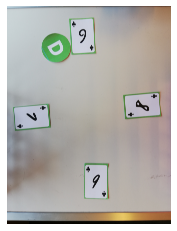

In [51]:
# Load an image an convert it RGB for display
test_im = cv2.imread('./games/game6/6.jpg')
test_im_rgb = cv2.cvtColor(test_im, cv2.COLOR_BGR2RGB)
plt.imshow(test_im_rgb)
plt.axis("off")

We perform a segmentation on the sample to find the contour and center of all the card, and dealer, and crop
the suite and value of the card of each player.

Dealer is Player:  3


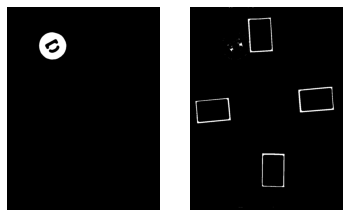

In [52]:
# Perform segmentation on it
cards, dealer = find_green_boxes(test_im)
contour_dealer, contours_card, M_player, M_dealer, M_suit, suit_img, value_img, dealer_assign = segmentation(cards, dealer,test_im)

fig, ax = plt.subplots(1,2)
ax[0].imshow(dealer, cmap="gray")
ax[0].axis("off")
ax[1].imshow(cards, cmap="gray")
ax[1].axis("off")
print("Dealer is Player: ", np.argmax(dealer_assign)+1)

Let's plot the contour around the segmented card and dealer marker. The small dot in the middle of the contour
indicate the contour center. The larger dot on the suite of the card indicate the center of the suite image.

Text(428, 581, 'Dealer')

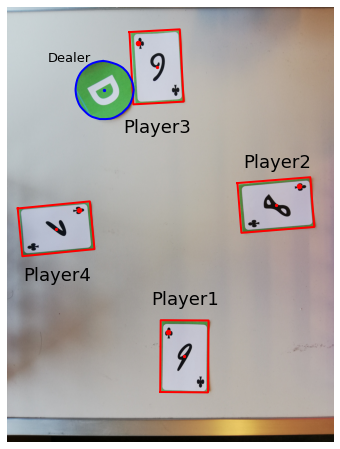

In [53]:
# Plot the boudaries
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(test_im_rgb)
ax.axis("off")

for contour in contours_card:
    ax.plot(contour[:,0],contour[:,1],'r',lw=2)

for player_nb, M in enumerate(M_player):
    ax.scatter(M[0],M[1],s=5,c='r')
    text = "Player"+ str(player_nb+1)
    if player_nb == 0:
        ax.text(M[0]-350, M[1]-550, text, fontsize= 18)
    elif player_nb == 1:
        ax.text(M[0]-350, M[1]-400, text, fontsize= 18)
    elif player_nb == 3:
        ax.text(M[0]-350, M[1]+550, text, fontsize= 18)
    else:
        ax.text(M[0]-350, M[1]+700, text, fontsize= 18)

for M in M_suit:
    ax.scatter(M[0],M[1],s=20,c='r')

ax.plot(contour_dealer[:,0],contour_dealer[:,1],'b',lw=2)
ax.scatter(M_dealer[0],M_dealer[1],s=5,c='b')
ax.text(M_dealer[0]-600, M_dealer[1]-300, "Dealer", fontsize=13)

### Decision Format Functions

Here, we declare a result formatting function that takes the result from the classification, compute the score, and output in the required formatting.
It also saved the result to the csv file.

In [54]:
suite_dict = {
    0 : "C", # Club
    1 : "D", # Diamond
    2 : "H", # Heart
    3 : "S"  # Spade
}

value_dict = {
    0 : "0",
    1 : "1",
    2 : "2",
    3 : "3",
    4 : "4",
    5 : "5",
    6 : "6",
    7 : "7",
    8 : "8",
    9 : "9",
    10 : "J", # Jack
    11 : "Q", # Queen
    12 : "K"  # King
}

def find_player_with_highest_card(card_value):
    winner = np.argwhere(card_value == np.amax(card_value))
    winner = winner.flatten()
    return winner

def decision(game, save_to_csv = False):
    ranks = [["0D"]*4]*13
    ranks = np.array(ranks)
    dealer = []
    standard_score = np.zeros(4)
    advanced_score = np.zeros(4)

    # Parse game into rank matrix
    for g_idx in range(len(game)):
        card_matrix = game[g_idx]

        for p_idx in range(card_matrix.shape[1]):
            ranks[g_idx,p_idx] = "{}{}".format(value_dict[card_matrix[0, p_idx]],
                                                suite_dict[card_matrix[1, p_idx]])

    for card_matrix in game:
        # Standard Game
        winner = find_player_with_highest_card(card_matrix[0,:])
        standard_score[winner] += 1

        # Advanced Game
        # Find dealer and his suite
        dealer_idx = np.argmax(card_matrix[2,:])
        active_suite = card_matrix[1, dealer_idx]
        dealer.append(dealer_idx + 1) # idx 0 is player 1 and so on

        # Copy game_card_value
        game_card_value = card_matrix[0, :].copy()

        # Filter GGed players
        GG_players = np.where(card_matrix[1,:] != active_suite)
        game_card_value[GG_players] = -1

        # Find winner
        winner = find_player_with_highest_card(game_card_value)
        advanced_score[winner] += 1

    # Save to csv
    if save_to_csv:
        ranks_df = pd.DataFrame(ranks, columns=['P1', 'P2', 'P3', 'P4'])
        dealer_df = pd.DataFrame(dealer, columns =['D'])
        game_df = ranks_df.join(dealer_df)
        game_df.index += 1
        game_df.to_csv(r'./game.csv', header=True, index=True)

    return ranks, list(dealer), list(standard_score.astype(int)), list(advanced_score.astype(int))

### Classification functions

#### Card Value
We used an MLP classifier to classify the value of the card
The classifier was trained with MNIST samples and the three extra figure.
For more information regarding the training of the classifier, please check the [`value_classifier.ipynb`](value_classifier.ipynb)

Here, we just import the pre-trained classifier.

In [55]:
filename = './data/value_classifier_256_995_980.mdl'
predictor = ValueClassifier(filename)

c:\users\tecni\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
c:\users\tecni\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


#### Card Suite
We firstly used a linear classifier to classify the color of suite. (Red for heart & diamond; Black for spade and club)
We then extracted the fourier descriptors of suite contours and used a Bayesian classifier to classify between the suite of same color.
For different color suites we take different fourier coefficients. To distinguish between diamond and heart (red), we take lower frequency descriptors as the difference mainly lies in overall shapes. To distinguish between club and spade (black), we take higher frequency descriptors as the difference mainly lies in details.

For more information regarding the linear classifier of red and black and the Bayesian classifier, please check the [`Bayesian classifier.ipynb`](Bayesian_classifier.ipynb)

Here, we just use the feature extraction function and final calculated decision function from test set.

In [56]:
def get_fourier_descriptors(im):
    #preprocessing to remove blue&green contours
    hsv_fg = skimage.color.rgb2hsv(im)
    hsv_fg = skimage.img_as_ubyte(hsv_fg)
    #find green contours (union of green and blue mask)
    green_mask = cv2.inRange(hsv_fg, (45,30,30), (115, 255,255))
    blue_mask = cv2.inRange(hsv_fg, (115,125,125), (150, 255,255)) 
    bg_mask = cv2.bitwise_or(green_mask,blue_mask)
    open_mask = cv2.morphologyEx(bg_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
    open_mask_inv = cv2.bitwise_not(open_mask)
    #keep foreground with inverse of mask
    img_fg = cv2.bitwise_and(im,im,mask = open_mask_inv)
    img_empty = np.ones_like(img_fg)*255
    #set background to empty
    img_bg = cv2.bitwise_and(img_empty,img_empty,mask = open_mask)
    img_fgbg = cv2.add(img_fg,img_bg)
    #threshold image
    thresh_im = clean_img(img_fgbg)
    # We use RETR_EXTERNAL mode to find external contour, CHAIN_APPROX_NONE to keep all points without simplification.
    contour = cv2.findContours(thresh_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[0] 
    # Keep the biggest contour only (the contour of suite shape)
    contour = sorted(contour, key=cv2.contourArea,reverse=True)
    contour_array = contour[0][:, 0, :]
    # color classification
    # create a mask of biggest contour
    color_mask = np.zeros_like(thresh_im)
    cv2.drawContours(color_mask, contour, 0, (255,255,255), -1)
    #calculate the average red channel value of shape
    red = cv2.mean(im, mask=color_mask)[2]
    # shape classification
    # Create an array storing the contour points in complex numbers
    contours_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contours_complex.real = contour_array[:, 0]
    contours_complex.imag = contour_array[:, 1]
    # Compute discrete Fourier Transform and get the amplitude
    fourier_result = np.fft.fft(contours_complex) 
    fourier_norm = np.absolute(fourier_result)
    # We abandon the 0's Fourier descriptor because it is variant to positions. 
    # We use first descriptor for normalizing all descriptors by the first one
    fourier_norm = fourier_norm/fourier_norm[1]
    isred = 0
    if (red > 100):
        isred = 1
        return fourier_norm[2], fourier_norm[3], isred
    else:
        return fourier_norm[6], fourier_norm[7], isred
    #2,3 for red set classification, diamond vs heart. Low frequency.
    #6,7 for black set classification, spade vs club. High frequency.

Define bayes classifiers to distinguish between suits of same color. The distinguish of color is done already while extracting fourier descriptors.

In [57]:
# The value of bayesian classifier's decision curve is calculated in the notebook Bayesian classifier.ipynb. 
# The classifier is a binary classifier works on top of the knowledge of the color of suite image.
def bayes_spade_club(x1,x2):
    if (2859.89042987933*x1**2 - 1233.09652151866*x1*x2 + 50.9525608771483*x1 - 3840.76833708728*x2**2 + 648.062279494321*x2 - 38.7202501408227 > 0):
        return 3
    else:
        return 0
def bayes_diamond_heart(x1,x2):
    if (-8631.68822729593*x1**2 + 334.043833410848*x1*x2 + 28.8862082239766*x1 - 401.333957105818*x2**2 + 743.09053520083*x2 - 182.895039049464 > 0):
        return 1
    else:
        return 2

## Using the functions to predict the game
We have all the required function to perform the segmentation, image processing and classification.
We will start to perform the classification on the dataset.

Here are some configurable parameter for the data loading

In [58]:
game_location = "./games/"
games_folder = os.listdir(game_location)
turns = 13

# Plot boundaries
plot_bound = True

First, we load the image of all game from the dataset.

In [59]:
game_count = len(games_folder)
#read data from test set
test_img_raw = []
for game in games_folder:
# different from training set, we don't have labels this time
    for i in range(turns):
        test_img_raw.append(cv2.imread(game_location+game+'/'+str(i+1)+'.jpg'))

Then, we segment the image and draw contours for demonstration for the first game.

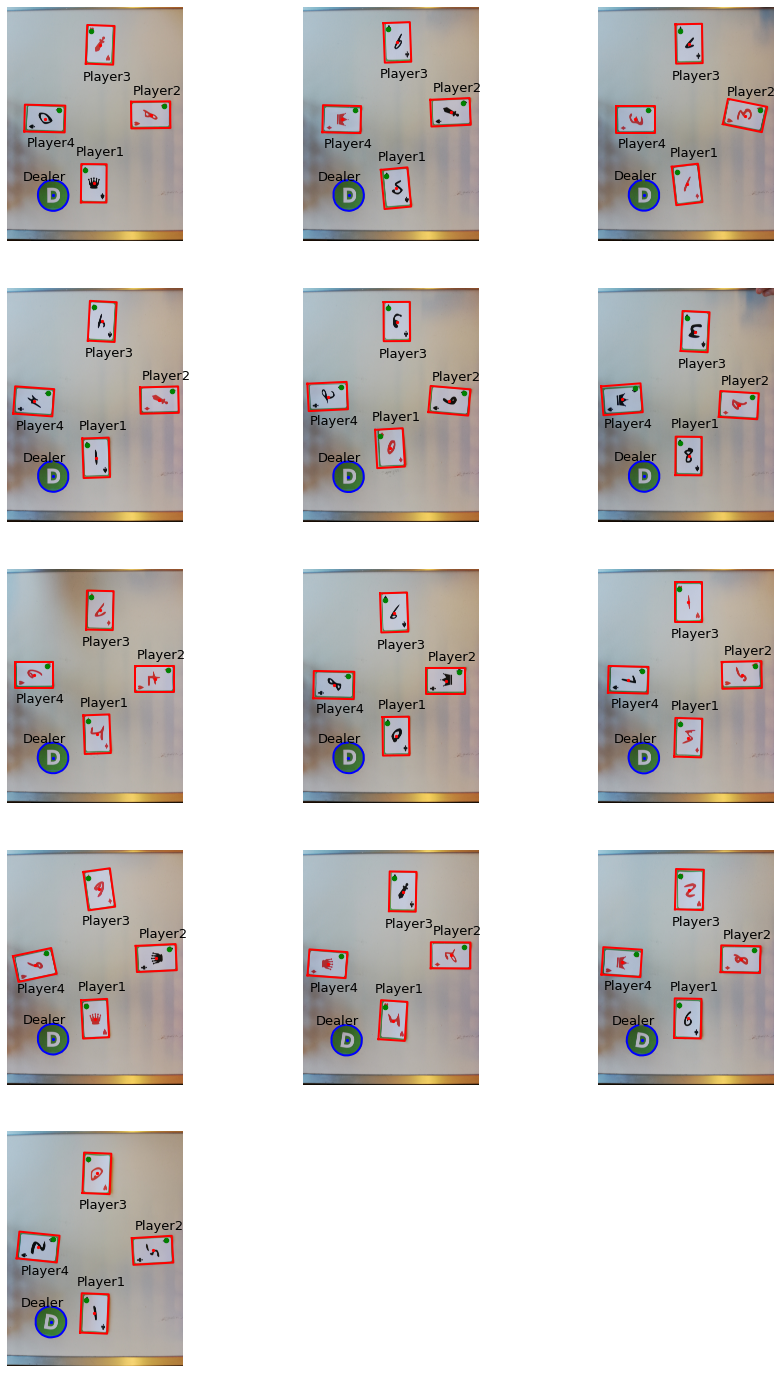

In [60]:
suit_img_testing = []
value_img_testing = []
dealer_testing = []

if plot_bound:
    fig_bound = plt.figure(figsize=(15,25))

for img_nb in range(len(test_img_raw)):
    cards, dealer = find_green_boxes(test_img_raw[img_nb])

    contour_dealer, contours_card, M_player, M_dealer, M_suit, suit_img, value_img, dealer_assign\
        = segmentation(cards, dealer,test_img_raw[img_nb])

    for player in range(0,4):
        suit_img_testing.append(suit_img[player])
        value_img_testing.append(value_img[player])
        dealer_testing.append(dealer_assign[player])

    if plot_bound and img_nb < 13:
        fig_bound.add_subplot(5, 3, img_nb+1)
        test_im_rgb = cv2.cvtColor(test_img_raw[img_nb], cv2.COLOR_BGR2RGB)
        plt.imshow(test_im_rgb)
        plt.axis("off")

        for contour in contours_card:
            plt.plot(contour[:,0],contour[:,1],'r',lw=2)

        for player_nb, M in enumerate(M_player):
            plt.scatter(M[0],M[1],s=5,c='r')
            text = "Player"+ str(player_nb+1)
            if player_nb == 0:
                plt.text(M[0]-350, M[1]-550, text, fontsize= 13)
            elif player_nb == 1:
                plt.text(M[0]-350, M[1]-400, text, fontsize= 13)
            elif player_nb == 3:
                plt.text(M[0]-350, M[1]+550, text, fontsize= 13)
            else:
                plt.text(M[0]-350, M[1]+700, text, fontsize= 13)

        for M in M_suit:
            plt.scatter(M[0],M[1],s=20,c='g')

        plt.plot(contour_dealer[:,0],contour_dealer[:,1],'b',lw=2)
        plt.scatter(M_dealer[0],M_dealer[1],s=5,c='b')
        plt.text(M_dealer[0]-600, M_dealer[1]-300, "Dealer", fontsize=13)

After that, we use the pre-trained classifier to predict the value of the card.

In [61]:
value = predictor.predict(np.array(value_img_testing))

Next, we classify the card suite using the fourier_descriptors on a bayes classifier.

In [62]:
suit = [] 
for i in range(len(test_img_raw) * 4):
    color = get_fourier_descriptors(suit_img_testing[i])[2]
    if color == 0: #black
        suit.append(bayes_spade_club(get_fourier_descriptors(suit_img_testing[i])[0],get_fourier_descriptors(suit_img_testing[i])[1]))
    else: #red
        suit.append(bayes_diamond_heart(get_fourier_descriptors(suit_img_testing[i])[0],get_fourier_descriptors(suit_img_testing[i])[1]))

After having all the required classification, we combine the result into a `card_matrix` for the output formatter and
score counter to work on.

In [63]:
all_game = []
for i in range(game_count):
    turn = []
    for j in range(turns):
        card_matrix = []
        value_turn = []
        suite_turn = []
        dealer_turn = []

        for player_nb in range(0,4):
            value_turn.append(value[i*turns*4+j*4+player_nb])
            suite_turn.append(suit[i*turns*4+j*4+player_nb])
            dealer_turn.append(dealer_testing[i*turns*4+j*4+player_nb])

        card_matrix.append(value_turn)
        card_matrix.append(suite_turn)
        card_matrix.append(dealer_turn)
        turn.append(np.array(card_matrix,dtype=object))

    all_game.append(turn)

### Final Result
Here are the result and accuracy of the game 4 (index 3).

In [64]:
pred_rank, pred_dealer, pred_pts_stand, pred_pts_advan = decision(all_game[3])

print_results(
    rank_colour=pred_rank,
    dealer=pred_dealer,
    pts_standard=pred_pts_stand,
    pts_advanced=pred_pts_advan,
)

The cards played were:
[
['7C', 'JH', '6C', 'JS'], 
['3H', 'JC', '9C', 'KH'], 
['3C', '5S', '7S', '4S'], 
['3D', '9D', '8D', '8S'], 
['4C', 'QH', '2C', 'QD'], 
['1H', '0H', '1D', '0S'], 
['JC', '9S', '7H', '0D'], 
['1C', '2D', '0C', '5D'], 
['2S', '5C', '4D', '1S'], 
['2H', '8H', 'KC', '4H'], 
['6H', '3S', '5H', '8H'], 
['6D', '7S', 'JD', 'QC'], 
['KS', '7D', 'QS', 'KD'], 
]
Players designated as dealer: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Players points (standard): [3, 4, 3, 7]
Players points (advanced): [4, 2, 6, 1]


If there ground truth file is available, we can compute the accuracy of the prediction with the cell below.

In [65]:
# Load ground truth from game
cgt = pd.read_csv('./games/game4/game4.csv', index_col=0)
cgt_rank = cgt[['P1', 'P2', 'P3', 'P4']].values

# Compute accuracy of prediction
acc_standard = evaluate_game(pred_rank, cgt_rank, mode_advanced=False)
acc_advanced = evaluate_game(pred_rank, cgt_rank, mode_advanced=True)
print("Your model accuracy is: Standard={:.3f}, Advanced={:.3f}".format(acc_standard, acc_advanced))


Your model accuracy is: Standard=0.942, Advanced=0.942


To visualize the result of the segmentation and classification algorithm, we show the segmented and processed image and
their classification result for all games below.

For the suite, note that class 0 = Club, 1 = Diamond, 2 = Heart, and 3 = Spade

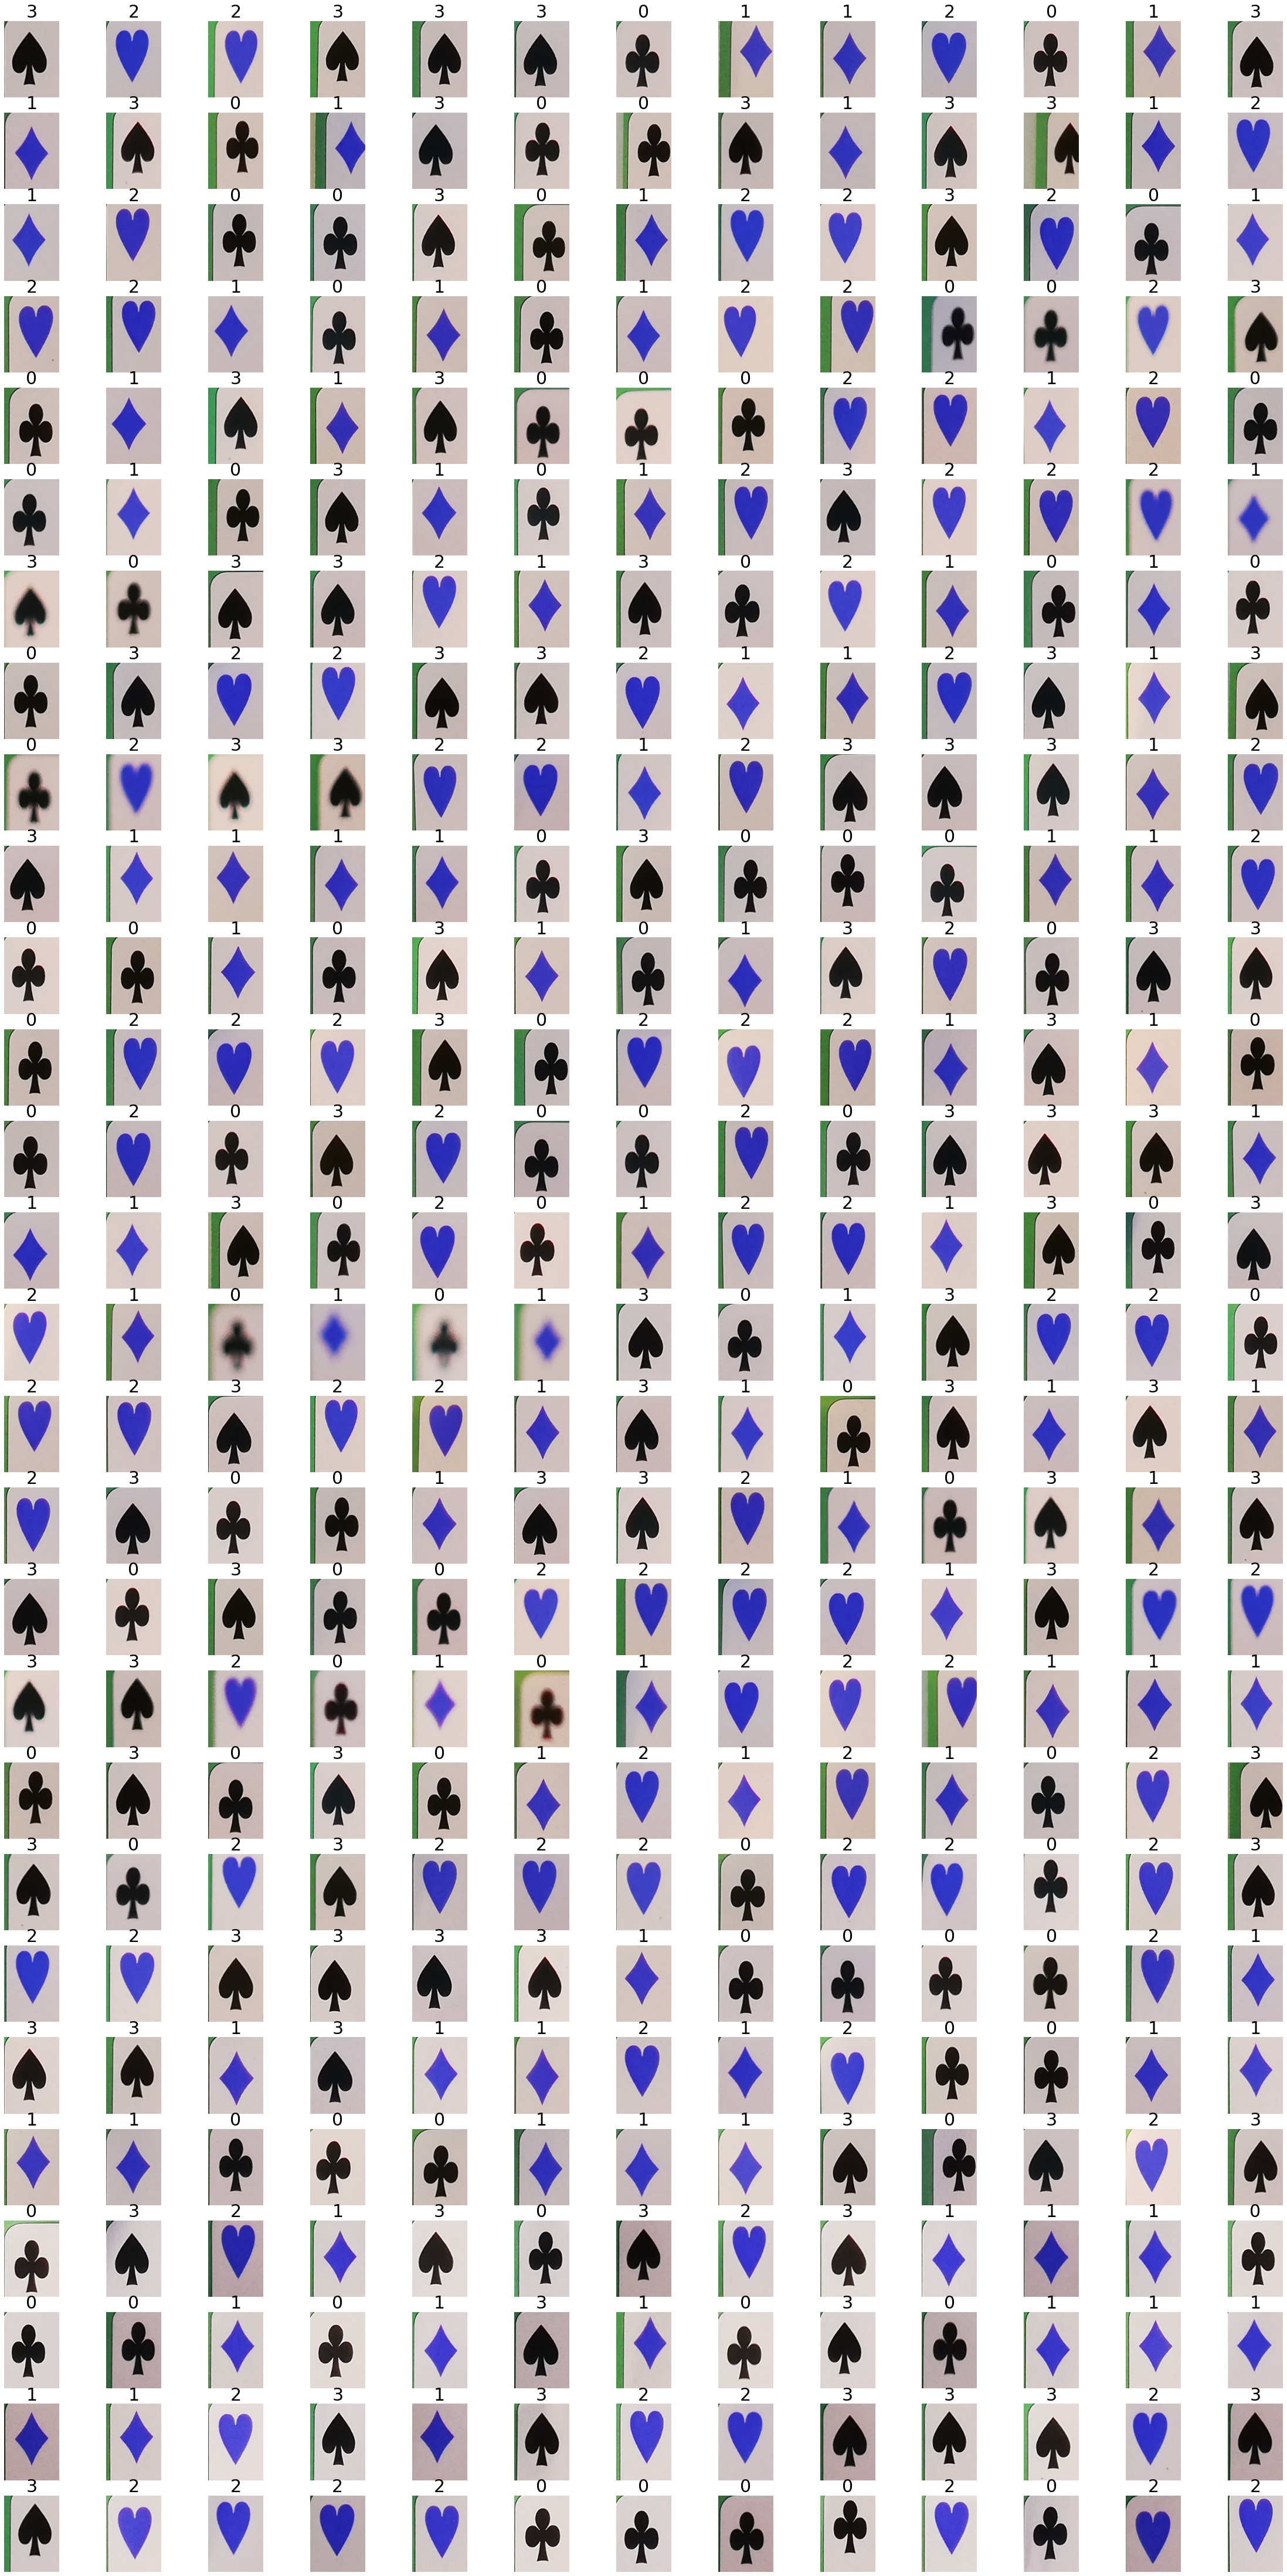

In [66]:
fig_suit=plt.figure(figsize=(40, 80))
for i in range(1, 13*7*4+1):
    fig_suit.add_subplot(28, 13, i)
    plt.imshow(suit_img_testing[i-1])
    plt.title(suit[i-1],fontsize=30)
    plt.axis('off')

As we can see from the result of the suite classification, the classifier does a perfect job at classifying
the suite, no mis-classification even with a blurry image.


For the value, note that class 0~9 correspond to the numerical value, 10 = Jack, 11 = Queen, and 12 = King.

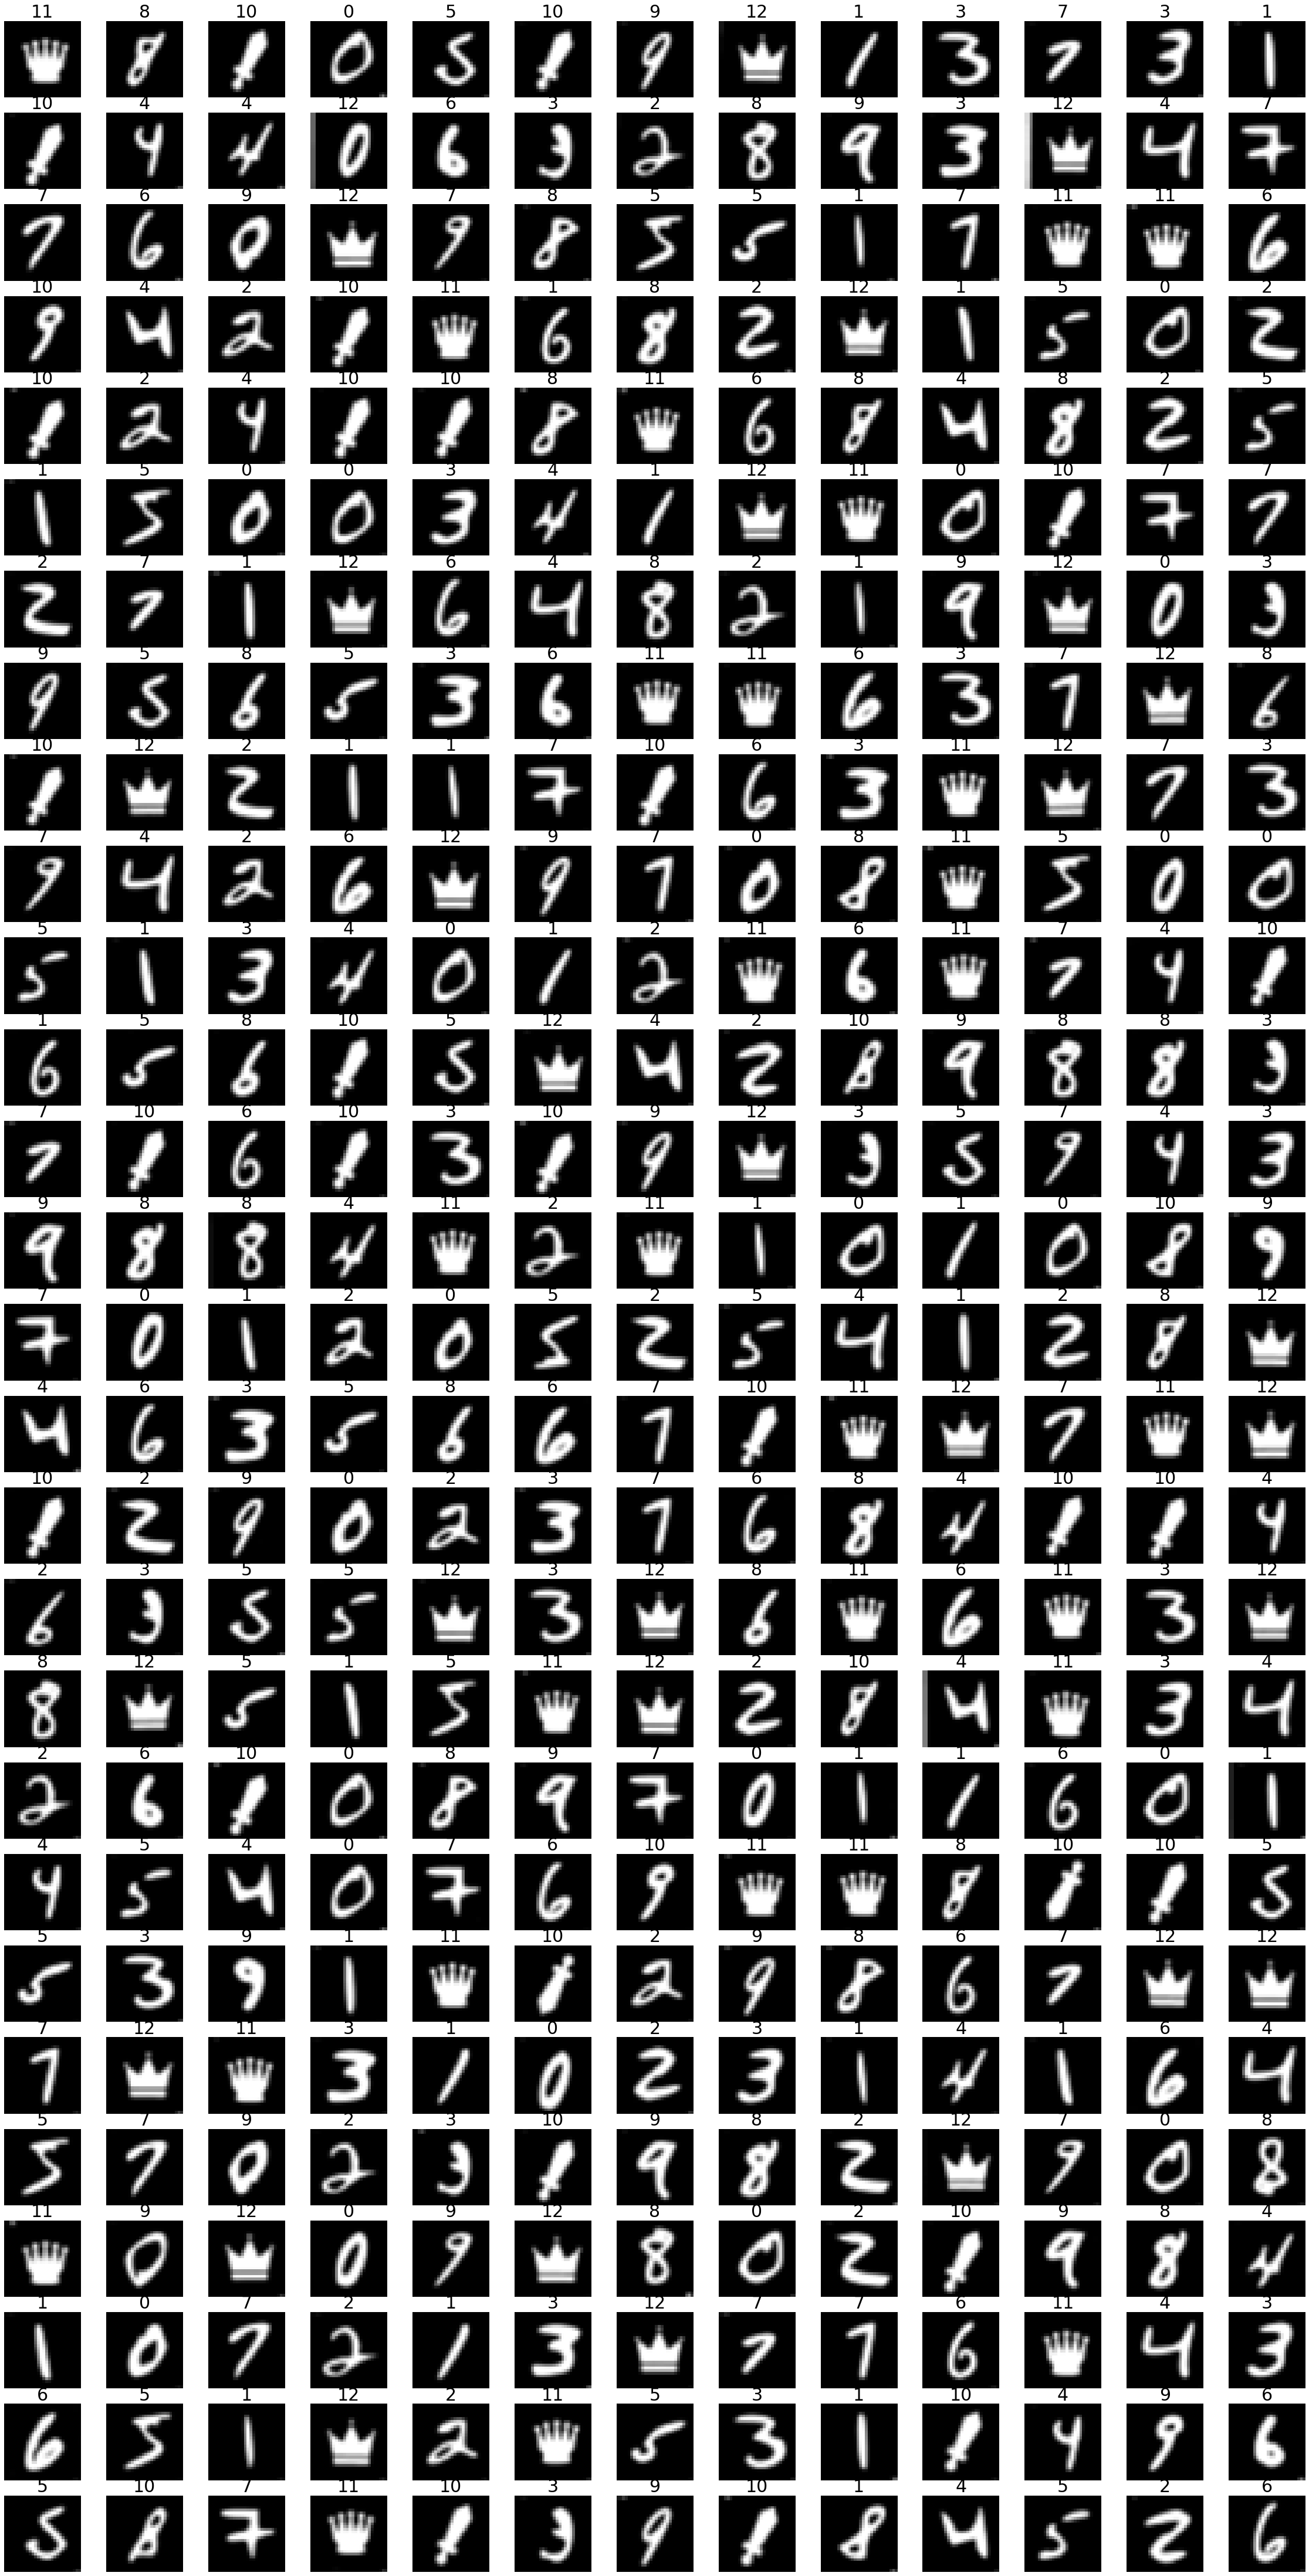

In [67]:
fig_value=plt.figure(figsize=(40, 80))
for i in range(1, 13*7*4+1):
    fig_value.add_subplot(28, 13, i)
    plt.imshow(value_img_testing[i-1],cmap='gray')
    plt.title(value[i-1],fontsize=30)
    plt.axis('off')

As we can see from the result of the value classification, the classifier mis-classified 18 images out of 364. So, that is a ~95% accuracy.
The model that we used is an MLP with two hidden layers 256 nodes each. The accuracy on the training and testing dataset is 99.5% and 98.0%
Here we achieve 95% accuracy, which is quite good as it is close to the testing value.

Eventhough, the image segmented from the card is from MNIST and the figure is the same figure that we used to in training, but the position,
 sharpness, and size might differ which causes the prediction to be less accurate than those of the testing and training set. Which is expected.